Let's make some exmaples of how MAF computes astrometry uncertainties

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import lsst.sims.maf.stackers as stackers

In [2]:
# First, let's observe a star with 2.5" of parallax
parallax_amp = 2.5
mjd0 = 59580.
npts = 20
names=['RA', 'dec', 'mjd', 'ra_pi_amp', 'dec_pi_amp', 'ra_offset', 'dec_offset']
types=[float, float, float, float, float, float, float]
data = np.zeros(npts, dtype=list(zip(names, types)))

data['mjd'] = np.arange(npts)/(npts-1.) * 365.25 + mjd0

# Set the coordinates in the sky of where we are putting our star
data['RA'] = 0
data['dec'] = -15.

In [3]:
# Stacker adds the amplitude of a 1" parallax star
stacker = stackers.ParallaxFactorStacker(raCol='RA', decCol='dec', dateCol='mjd')

In [4]:
data = stacker._run(data)
# The actual offset of the star is the amplitdude times the stacked vector
data['ra_offset'] = parallax_amp*data['ra_pi_amp']
data['dec_offset'] = parallax_amp*data['dec_pi_amp']

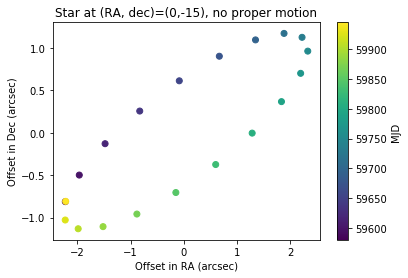

In [5]:
plt.scatter(data['ra_offset'], data['dec_offset'], c=data['mjd'])
plt.xlabel('Offset in RA (arcsec)')
plt.ylabel('Offset in Dec (arcsec)')
plt.title('Star at (RA, dec)=(%i,%i), no proper motion' % (data['RA'][0], data['dec'][0]))
cb = plt.colorbar()
cb.set_label('MJD')

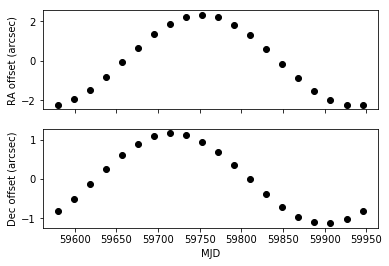

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False)

ax1.plot(data['mjd'], data['ra_offset'], 'ko')
ax1.set_ylabel('RA offset (arcsec)')
ax2.plot(data['mjd'], data['dec_offset'], 'ko')
ax2.set_xlabel('MJD')
ax2.set_ylabel('Dec offset (arcsec)')

Here we are assuming that the true, un-parallax shifted postion of the star is known (or at least fit and the fit has no covarience with the amplitude fit). This is inherently untrue for when observations cover only a limited amount of the phase.

For stars at different distances, the shape of these curves remains the same and the amplitude changes. If we know the zero position, we can then use each observation as an independent measurement of the amplitude. 

Let's assume a constant error in both the x and y centroiding. Then we get

In [7]:
# Assume all observations taken with FWHM of 1 arcsec and SNR of 5.
# MAF of course replaces these values with the actual seeing and depth values for each observation.
fwhm = 1.0 
snr = 5.
# The origins of this equation are murky at best. An excellent imsim+DM pipeline exercise would be verifying this.
# 
centroid_error = fwhm/snr  

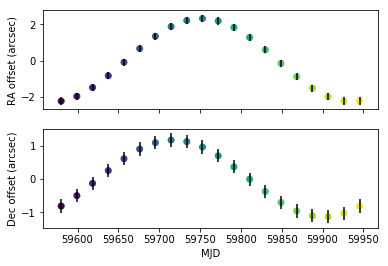

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False)

ax1.errorbar(data['mjd'], data['ra_offset'], yerr=centroid_error, fmt='none', ecolor='k')
ax1.scatter(data['mjd'], data['ra_offset'], c=data['mjd'])
ax2.errorbar(data['mjd'], data['dec_offset'], yerr=centroid_error, fmt='none', ecolor='k')
ax2.scatter(data['mjd'], data['dec_offset'], c=data['mjd'])

ax1.set_ylabel('RA offset (arcsec)')
ax2.set_xlabel('MJD')

ax2.set_ylabel('Dec offset (arcsec)')

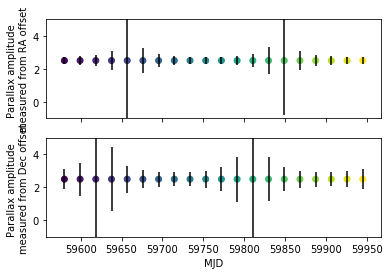

In [9]:
# The uncertainty in parallax amplitude, as measured by each point is then
amp_from_ra = data['ra_offset']/data['ra_pi_amp']
amp_from_ra_err = centroid_error / data['ra_pi_amp']

amp_from_dec = data['dec_offset']/data['dec_pi_amp']
amp_from_dec_err = centroid_error / data['dec_pi_amp']


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False)
ax1.errorbar(data['mjd'], amp_from_ra, yerr=amp_from_ra_err, fmt='none', ecolor='k')
ax2.errorbar(data['mjd'], amp_from_dec, yerr=amp_from_dec_err, fmt='none', ecolor='k')
ax1.scatter(data['mjd'], amp_from_ra, c=data['mjd'])
ax2.scatter(data['mjd'], amp_from_dec, c=data['mjd'])

ax1.set_ylim([-1,5])
ax2.set_ylim([-1,5])
ax2.set_xlabel('MJD')
ax1.set_ylabel('Parallax amplitude \nmeasured from RA offset')
ax2.set_ylabel('Parallax amplitude \nmeasured from Dec offset')


In [10]:
# we can then compute the final uncertainty in the parallax as determined by just the RA offset and just the dec as
sigma_ra = np.sqrt(1./np.sum((1./amp_from_ra_err**2)))
sigma_dec = np.sqrt(1./np.sum((1./amp_from_dec_err**2)))
print('Amplitude uncertainty from RA=%.3f arcsec' % sigma_ra,)
print('Amplitude uncertainty from dec=%.3f arcsec' % sigma_dec)

Amplitude uncertainty from RA=0.067 arcsec
Amplitude uncertainty from dec=0.137 arcsec


In [11]:
# and combining those two
sigma_final = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))
print('final uncertainty in parallax ampiltude=%.3f arcsec' % sigma_final)

final uncertainty in parallax ampiltude=0.060 arcsec


In [12]:
envelope = centroid_error/np.sqrt(npts)
print('for comparison, our single-measurment error divided by root-N = %.3f' % envelope)


for comparison, our single-measurment error divided by root-N = 0.045


An important point is that the actual amplitude of the parallax cancels out and does not influence the uncertainty of the parallax uncertainty. The relevant parameters are the dates and centroiding errors. Go ahead and run with different parallax amplitudes!